In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

In [3]:
folder = r'./kobe-bryant-shot-selection/'
data = pd.read_csv(folder + 'data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [24]:
data['loc_y'].describe()

count    30697.000000
mean        91.107535
std         87.791361
min        -44.000000
25%          4.000000
50%         74.000000
75%        160.000000
max        791.000000
Name: loc_y, dtype: float64

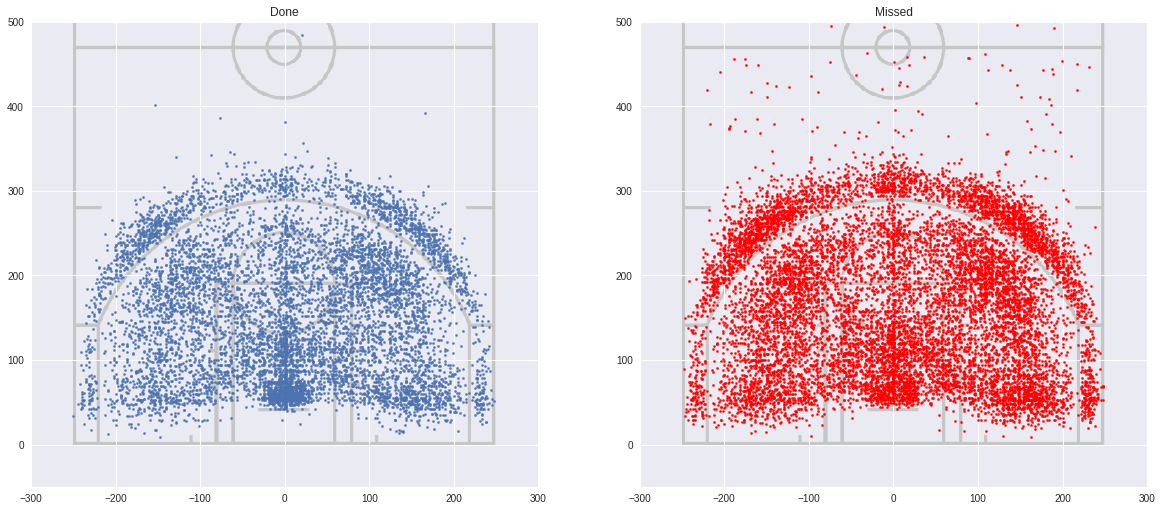

In [28]:
# http://savvastjortjoglou.com/nba-play-by-play-movements.html
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
court = plt.imread(folder + "fullcourt.png")
court = np.transpose(court, (1, 0, 2))

ax1.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax1.scatter(data['loc_x'][data['shot_made_flag'] == 1], data['loc_y'][data['shot_made_flag'] == 1] + 52.5, s=5)
ax1.set(xlim=[-300, 300], ylim=[-50, 500], aspect=1)
ax1.set_title('Done')

ax2.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax2.scatter(data['loc_x'][data['shot_made_flag'] == 0], data['loc_y'][data['shot_made_flag'] == 0] + 52.5, s=5, color='red')
ax2.set(xlim=[-300, 300], ylim=[-50, 500], aspect=1)
ax2.set_title('Missed')

f.gca().set_aspect('equal')
f.subplots_adjust(hspace=0)
plt.show()

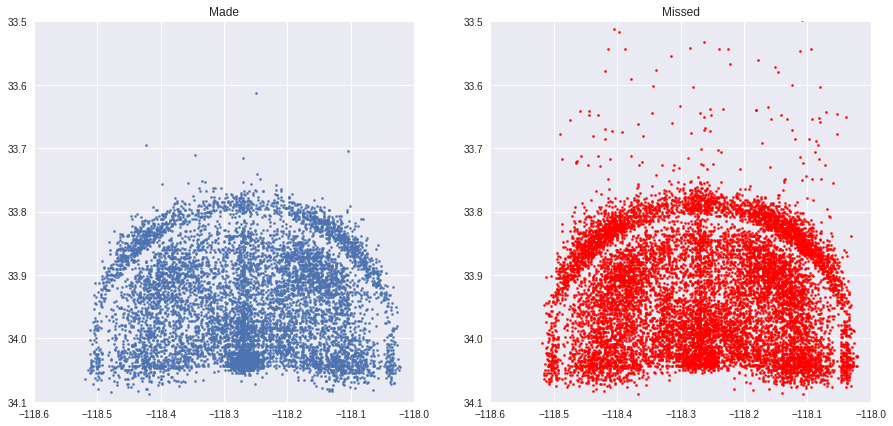

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.scatter(data['lon'][data['shot_made_flag'] == 1], data['lat'][data['shot_made_flag'] == 1], s=5)
ax2.scatter(data['lon'][data['shot_made_flag'] == 0], data['lat'][data['shot_made_flag'] == 0], s=5, color='red')
ax1.set(xlim=[-118.6, -118], ylim=[34.1, 33.5], aspect=1)
ax1.set_title('Made')
ax2.set(xlim=[-118.6, -118], ylim=[34.1, 33.5], aspect=1)
ax2.set_title('Missed')
f.gca().set_aspect('equal')
f.subplots_adjust(hspace=0)
plt.show()

In [97]:
drop_columns = ['game_id', 'game_event_id', 'team_id', 'team_name', 'lat', 'lon']
data.drop(drop_columns, axis=1, inplace=True)

In [98]:
data['home'] = data['matchup'].str.contains('vs').astype(int)
data.drop('matchup', axis=1, inplace=True)

In [99]:
data['month'] = data['game_date'].str[5:7]
data.drop('game_date', axis=1, inplace=True)

In [100]:
data.sample(10)

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,shot_id,home,month
16485,Driving Layup Shot,Layup,-21,9,9,3,0,2010-11,52,2,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,GSW,16486,1,10
9791,Jump Shot,Jump Shot,115,128,6,2,0,2006-07,4,17,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,TOR,9792,1,11
23281,Jump Shot,Jump Shot,21,103,11,4,0,1996-97,32,10,NaN,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,DAL,23282,1,04
2230,Layup Shot,Layup,0,0,10,3,0,2001-02,40,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,MIA,2231,1,01
27122,Jump Shot,Jump Shot,131,-23,3,1,1,2002-03,50,13,0.0,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,MIN,27123,1,05
20429,Alley Oop Layup shot,Layup,9,6,0,2,0,2012-13,12,1,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,BKN,20430,0,02
14682,Jump Shot,Jump Shot,141,145,9,3,0,2008-09,57,20,NaN,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,NJN,14683,0,03
13219,Jump Shot,Jump Shot,226,-3,5,3,0,2008-09,40,22,0.0,3PT Field Goal,Right Side(R),Right Corner 3,24+ ft.,LAC,13220,1,11
27386,Reverse Layup Shot,Layup,0,0,4,1,1,2003-04,41,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,HOU,27387,1,04
4332,Driving Layup Shot,Layup,0,0,2,5,0,2002-03,8,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,HOU,4333,1,02


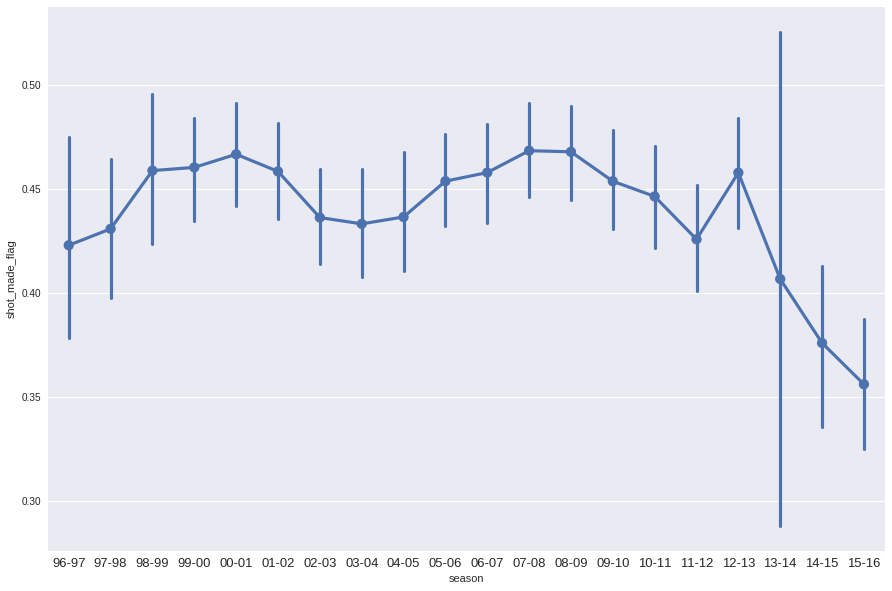

In [101]:
plt.figure(figsize=(15, 10))
ax = sns.pointplot(x='season', y='shot_made_flag', data=data, order=sorted(list(data['season'].unique())))
ax.set_xticklabels([x[2:] for x in sorted(list(data['season'].unique()))], fontsize=13)
plt.show()

0.44616103047048294

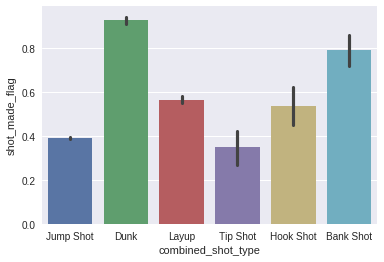

In [102]:
sns.barplot(x='combined_shot_type', y='shot_made_flag', data=data)
data['shot_made_flag'].mean()

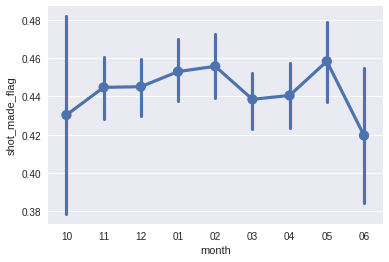

In [103]:
sns.pointplot(x='month', y='shot_made_flag', data=data, order=['10', '11', '12', '01', '02', '03', '04', '05', '06'])
plt.show()

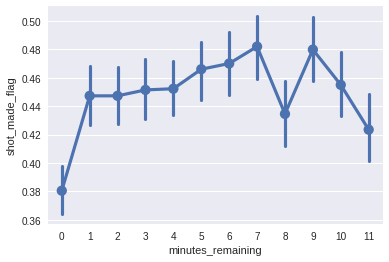

In [137]:
sns.pointplot(x='minutes_remaining', y='shot_made_flag', data=data)
plt.show()

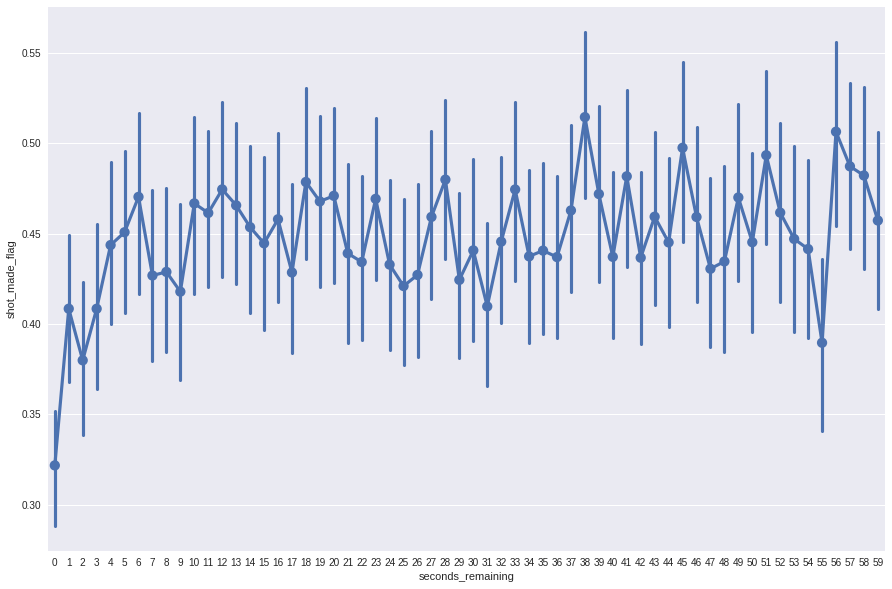

In [139]:
plt.figure(figsize=(15, 10))
sns.pointplot(x='seconds_remaining', y='shot_made_flag', data=data)
plt.show()

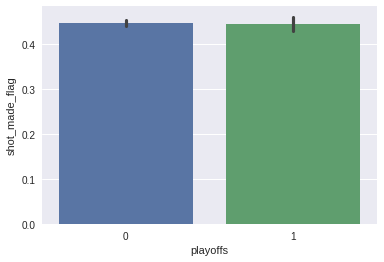

In [104]:
sns.barplot(x='playoffs', y='shot_made_flag', data=data)
plt.show()

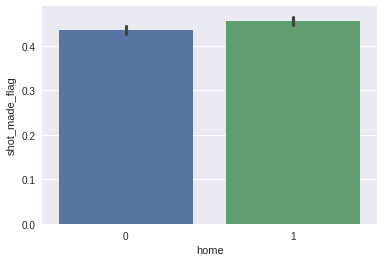

In [105]:
sns.barplot(x='home', y='shot_made_flag', data=data)
plt.show()

In [135]:
th = data.groupby('action_type')['combined_shot_type'].count() > 20
data['action_type_2'] = data.groupby(['action_type'])['action_type'].transform(lambda x: x.count())
data['action_type_2'] = np.where(data['action_type_2'] >= 20, data['action_type'], 'other')
data.drop('action_type', axis=1, inplace=True)

In [136]:
data.sample(10)

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,shot_id,home,month,action_type2,action_type_2
9128,Layup,0,0,6,3,0,2005-06,15,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,NOP,9129,0,03,NaN,Layup Shot
508,Jump Shot,32,257,2,1,0,2000-01,33,25,NaN,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,MIL,509,1,12,NaN,Jump Shot
21246,Jump Shot,-120,44,3,1,0,2014-15,52,12,1.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,NOP,21247,0,11,NaN,Jump Bank Shot
24164,Jump Shot,-119,242,0,3,0,1997-98,2,26,0.0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,VAN,24165,1,04,NaN,Jump Shot
12822,Jump Shot,-233,18,7,2,0,2007-08,47,23,0.0,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,DAL,12823,0,03,NaN,Jump Shot
15857,Jump Shot,-141,192,3,2,0,2009-10,10,23,0.0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,TOR,15858,0,01,NaN,Jump Shot
3377,Jump Shot,52,138,1,1,0,2002-03,13,14,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,DAL,3378,0,11,NaN,Jump Shot
23386,Jump Shot,113,61,8,4,0,1997-98,33,12,NaN,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,UTA,23387,0,11,NaN,Jump Shot
1319,Jump Shot,14,186,5,3,0,2000-01,18,18,NaN,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,SAS,1320,1,03,NaN,Jump Shot
6285,Jump Shot,-235,3,0,2,0,2004-05,5,23,0.0,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,NOP,6286,0,11,NaN,Jump Shot


In [108]:
data.loc[data['action_type'].str.contains('Dunk'), 'action_type2'] = 'Dunk'

In [114]:
data[data['action_type'].str.contains('Dunk')][data['shot_made_flag']==0]

/home/federico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,shot_id,home,month
46,Reverse Dunk Shot,Dunk,-4,4,2,3,0,2000-01,55,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,VAN,47,0,11
83,Slam Dunk Shot,Dunk,-8,4,10,1,0,2000-01,59,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,SAS,84,0,11
249,Dunk Shot,Dunk,0,0,6,3,0,2000-01,9,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,GSW,250,1,11
312,Running Dunk Shot,Dunk,0,0,1,3,0,2000-01,15,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,IND,313,1,11
376,Driving Dunk Shot,Dunk,0,0,1,2,0,2000-01,10,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,DAL,377,1,12
507,Dunk Shot,Dunk,0,0,4,1,0,2000-01,17,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,MIL,508,1,12
1260,Dunk Shot,Dunk,0,0,2,3,0,2000-01,48,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,GSW,1261,0,03
1382,Alley Oop Dunk Shot,Dunk,0,0,11,2,0,2000-01,6,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,ORL,1383,0,03
1401,Alley Oop Dunk Shot,Dunk,0,0,8,2,0,2000-01,39,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,ATL,1402,0,03
1855,Dunk Shot,Dunk,0,0,0,2,0,2001-02,40,0,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,SEA,1856,1,12


colormap en función de la temporada
https://stats.nba.com/media/img/fullcourt.svg
http://savvastjortjoglou.com/nba-play-by-play-movements.html
http://savvastjortjoglou.com/nba-shot-sharts.html